In [1]:
from icrawler.builtin import GoogleImageCrawler
from icrawler import ImageDownloader
import pandas as pd
from tqdm.notebook import tqdm
import os
import os.path
import glob
import random
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML

pd.set_option("display.max_colwidth", -1)

MAX_IMG_NUM = 10

## Prepare data

In [10]:
df_base = pd.read_csv("../../data/sparkrecipes_base.csv")

In [11]:
df_base.head()

,recipe_id,title,image_url,total_calories,url
0,0,Caribbean Black Beans and Rice,NaN,479.6,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=3
1,1,Minestrone Soup,NaN,153.1,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=4
2,2,20-Minute Chicken Creole,https://sparkpeo.hs.llnwd.net/e1/resize/630m620/e2/guid/20-Minute-Chicken-Creole-RECIPE/b07ff5c9-e386-4627-9437-6956414e5eb6.jpg,269.3,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=5
3,3,Beef and Vegetable Stir-Fry,NaN,245.5,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=6
4,4,Italian Vegetable Bake,https://sparkpeo.hs.llnwd.net/e1/resize/630m620/e4/nw/1/0/l103442818.jpg,37.2,https://recipes.sparkpeople.com/recipe-detail.asp?recipe=7


In [12]:
df_img_source = df_base[["recipe_id", "title", "total_calories"]][:5]
for i in range(1, MAX_IMG_NUM):
    df_img_source[f"image_{i}"] = df_img_source["recipe_id"].map(lambda id: f"../../data/images/{id}/{i:06d}")

In [13]:
df_img_source.head()

,recipe_id,title,total_calories,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9
0,0,Caribbean Black Beans and Rice,479.6,../../data/images/0/000001,../../data/images/0/000002,../../data/images/0/000003,../../data/images/0/000004,../../data/images/0/000005,../../data/images/0/000006,../../data/images/0/000007,../../data/images/0/000008,../../data/images/0/000009
1,1,Minestrone Soup,153.1,../../data/images/1/000001,../../data/images/1/000002,../../data/images/1/000003,../../data/images/1/000004,../../data/images/1/000005,../../data/images/1/000006,../../data/images/1/000007,../../data/images/1/000008,../../data/images/1/000009
2,2,20-Minute Chicken Creole,269.3,../../data/images/2/000001,../../data/images/2/000002,../../data/images/2/000003,../../data/images/2/000004,../../data/images/2/000005,../../data/images/2/000006,../../data/images/2/000007,../../data/images/2/000008,../../data/images/2/000009
3,3,Beef and Vegetable Stir-Fry,245.5,../../data/images/3/000001,../../data/images/3/000002,../../data/images/3/000003,../../data/images/3/000004,../../data/images/3/000005,../../data/images/3/000006,../../data/images/3/000007,../../data/images/3/000008,../../data/images/3/000009
4,4,Italian Vegetable Bake,37.2,../../data/images/4/000001,../../data/images/4/000002,../../data/images/4/000003,../../data/images/4/000004,../../data/images/4/000005,../../data/images/4/000006,../../data/images/4/000007,../../data/images/4/000008,../../data/images/4/000009


## Crawl images

In [14]:
def is_complete(dest_dir):
    return len([name for name in os.listdir(dest_dir) if os.path.isfile(os.path.join(dest_dir, name))]) >= MAX_IMG_NUM

class NoExtDownloader(ImageDownloader):
    def get_filename(self, task, default_ext):
        filename = super(NoExtDownloader, self).get_filename(
            task, default_ext)
        return filename.split(".")[0]

In [15]:
for _, row in tqdm(df_img_source.iterrows(), total=df_img_source.shape[0]):
    dest_dir = f"../../data/images/{row.recipe_id}"
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    if not is_complete(dest_dir):
        print(f"### Crawling images for recipe {row.title}")
        google_crawler = GoogleImageCrawler(downloader_cls=NoExtDownloader, storage={'root_dir': dest_dir})
        google_crawler.crawl(keyword=row.title, max_num=MAX_IMG_NUM, filters=dict(size="medium"))

## Display images

In [16]:
def get_thumbnail(path):
    i = Image.open(path).convert("RGB")
    i.thumbnail((224, 224), Image.LANCZOS)
    return i


def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, "jpeg")
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

,recipe_id,title,total_calories,image_1,image_2,image_3,image_4,image_5,image_6,image_7,image_8,image_9
0,0,Caribbean Black Beans and Rice,479.6,,,,,,,,,
1,1,Minestrone Soup,153.1,,,,,,,,,
2,2,20-Minute Chicken Creole,269.3,,,,,,,,,
3,3,Beef and Vegetable Stir-Fry,245.5,,,,,,,,,
4,4,Italian Vegetable Bake,37.2,,,,,,,,,

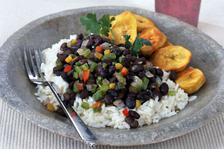
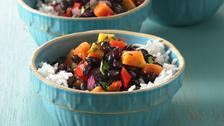
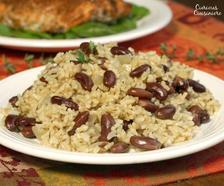
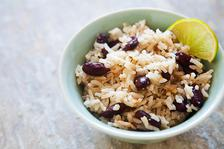
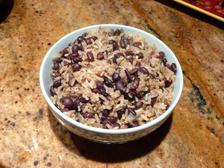
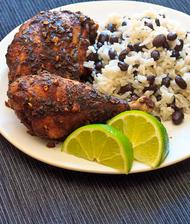
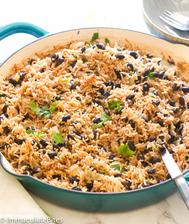
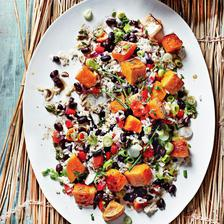
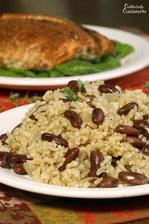
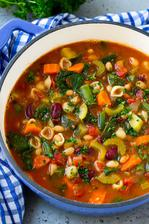
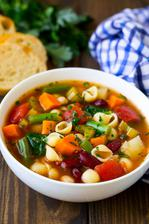
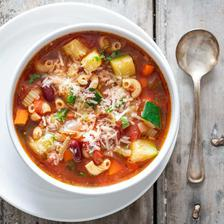
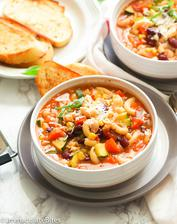
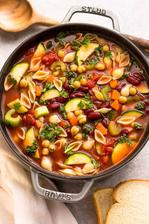
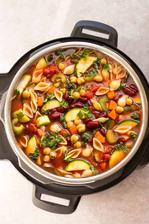
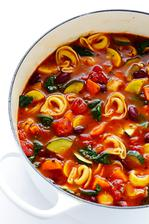
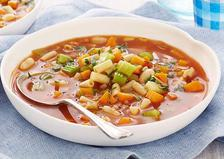
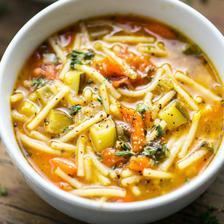
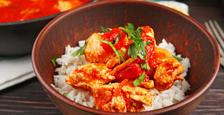
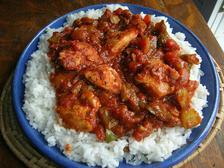
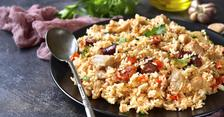
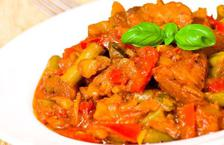
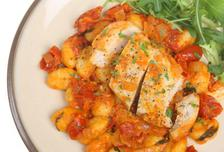
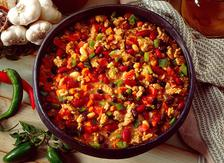
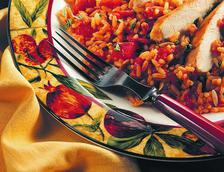
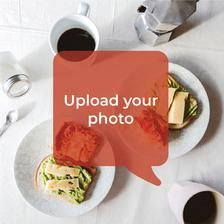
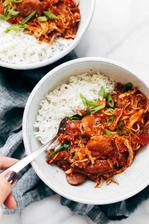
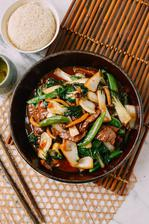
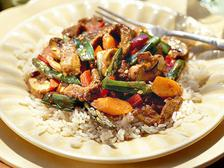
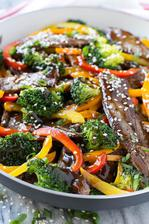
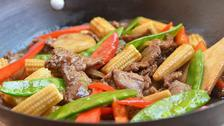
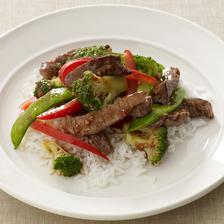
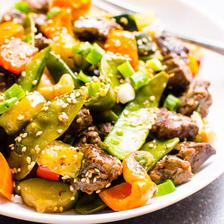
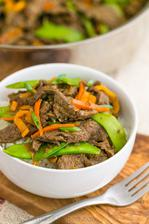
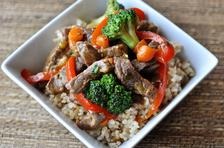
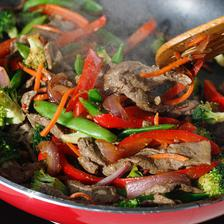
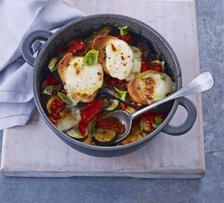
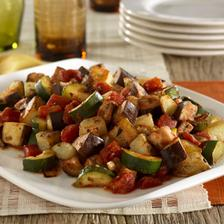
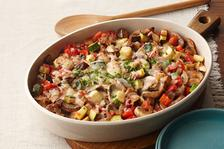
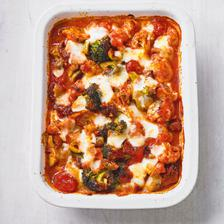
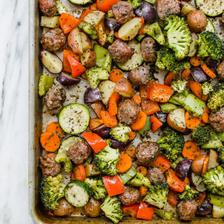
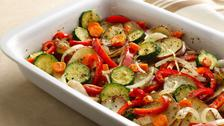
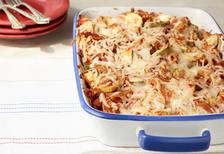
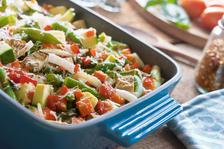
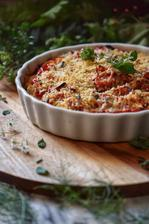

In [17]:
HTML(df_img_source.to_html(formatters={**{f"image_{i}": image_formatter for i in range(1, MAX_IMG_NUM)}}, escape=False))

## Persist results

In [24]:
df_out = df_img_source[["recipe_id"] + [f"image_{i}" for i in range(1, MAX_IMG_NUM)]]

In [25]:
df_out.to_csv("../../data/sparkrecipes_images.csv", index=False)